In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
import numpy as np
import nibabel as nib
import os
import pickle
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Function, Variable
from tqdm import tqdm
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [4]:
def ELU(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)
    
def n_conv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(single_conv(nchan, elu))
    return nn.Sequential(*layers)


class single_conv(nn.Module):
    def __init__(self, nchan, elu):
        super(single_conv, self).__init__()
        self.relu = ELU(elu, nchan)
        self.conv = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out


In [5]:
class input_layer(nn.Module):
    def __init__(self, in_ch, out_ch, elu):
        super(input_layer, self).__init__()

        self.conv = nn.Conv3d(in_ch,out_ch,kernel_size=5,padding=2)
        self.relu = ELU(elu, out_ch)
        self.bn = nn.BatchNorm3d(out_ch)
        
    def forward(self, x):
        # 1. Convolve
        out = self.conv(x)
        # 2. Normalize
        out = self.bn(out)
        # 3. Add concatenated output and input
        out = torch.add(out, x)
        # 4. Activation
        out = self.relu(out)
        return out
    

In [6]:
class down_layer(nn.Module):
    def __init__(self, in_ch, nConv, elu):
        super(down_layer, self).__init__()
        out_ch = 2*in_ch
        self.down_conv = nn.Conv3d(in_ch, out_ch, kernel_size=2, stride=2)
        self.bn = nn.BatchNorm3d(out_ch)
        self.relu = ELU(elu, out_ch)
        self.layers = n_conv(out_ch, nConv, elu)
        
    def forward(self, x):
        down = self.relu(self.bn(self.down_conv(x)))
        out = self.layers(down)
        out = self.relu(torch.add(out, down))
        return down, out

In [7]:
class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch, nConv, elu):
        super(up_layer, self).__init__()
        self.up_conv = nn.ConvTranspose3d(in_ch, out_ch//2 , kernel_size=2, stride=2)
        self.bn = nn.BatchNorm3d(out_ch//2 )
        self.relu1 = ELU(elu, out_ch//2 )
        self.relu2 = ELU(elu, out_ch)
        self.layers = n_conv(out_ch, nConv, elu)
        #self.do2 = nn.Dropout3d()

    def forward(self, x, skipx):
        out = self.relu1(self.bn(self.up_conv(x)))
        xcat = torch.cat((out, skipx), 1)
        out = self.layers(xcat)
        out = self.relu2(torch.add(out, xcat))
        return out

In [8]:
class output_layer(nn.Module):
    def __init__(self, in_ch, elu, nll):
        super(output_layer, self).__init__()
        self.conv1 = nn.Conv3d(in_ch, 2, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(2)
        self.conv2 = nn.Conv3d(2, 2, kernel_size=1)
        self.relu1 = ELU(elu, 2)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.softmax = F.softmax

    def forward(self, x):
        out = self.relu1(self.bn(self.conv1(x)))
        out = self.conv2(out)
        out = self.softmax(out)
        return out


In [9]:
class VNet(nn.Module):
    
    def __init__(self, elu=True, nll=False):
        super(VNet, self).__init__()
        #In
        self.input = input_layer(1, 16, elu)
        
        #Down
        self.down32 = down_layer(16, 2, elu)
        self.down64 = down_layer(32, 3, elu)
        self.down128 = down_layer(64, 3, elu)
        self.down256 = down_layer(128, 3, elu)
        
        #Up
        self.up256 = up_layer(256,256, 3, elu)
        self.up128 = up_layer(256,128, 3, elu)
        self.up64 = up_layer(128,64, 2, elu)
        self.up32 = up_layer(64,32, 1, elu)
        
        #Out
        self.output = output_layer(32, elu, nll)
    
    def forward(self, x):
        #Layer 1: In
        out16 = self.input(x)
        
        #Layer 2 : Down ( 2 conv layers deep)
        d_32, out32 = self.down32(out16)
        
        #Layer 3 : Down ( 3 conv layers deep)
        d_64, out64 = self.down64(out32)
        
        #Layer 4 : Down ( 3 conv layers deep)
        d_128, out128 = self.down128(out64)      
        
        #Layer 5 : Down ( 3 conv layers deep)
        d_256, out256 = self.down256(out128)
        
        #Layer 5 : up ( 3 conv layers deep)
        output = self.up256(out256, out128)

        #Layer 4 : up ( 3 conv layers deep)
        output = self.up128(output, out64)
        
        #Layer 3 : up ( 3 conv layers deep)
        output = self.up64(output, out32)
        
        #Layer 2 : up ( 2 conv layers deep)
        output = self.up32(output, out16)
        
        #Layer 1 : out
        output = self.output(output)
        
        return output

In [10]:
net = VNet(elu=False, nll=False)
#print(model)

In [11]:
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

Number of parameters in network:  65190654


In [12]:
# Path to the folder that contains folders of segmentation data
PATH = "data/TrainingDataset_MSSEG/"
# Takes all folders in the path 
PATH = PATH + "*/"
image_paths = []
mask_paths = []

block_size = (32,32,32)

directory_paths = glob(PATH)
for path in directory_paths:
    # Load all the paths for each Flair set of data (1 Flair data and all its segmentation paths)
    flair_path = path + '3DFLAIR.nii.gz'
    seg1_path = path + 'ManualSegmentation_1.nii.gz'
    seg2_path = path + 'ManualSegmentation_2.nii.gz'
    seg3_path = path + 'ManualSegmentation_3.nii.gz'
    seg4_path = path + 'ManualSegmentation_4.nii.gz'
    seg5_path = path + 'ManualSegmentation_5.nii.gz'
    seg6_path = path + 'ManualSegmentation_6.nii.gz'
    seg7_path = path + 'ManualSegmentation_7.nii.gz'
    image_paths.extend([flair_path,flair_path,flair_path,flair_path,flair_path,flair_path,flair_path])
    mask_paths.extend([seg1_path,seg2_path,seg3_path,seg4_path,seg5_path,seg6_path,seg7_path])


In [13]:
def split_train_val(image_paths, mask_paths, train_size):
    
    len_data = len(image_paths)
    print('total len:', len_data)

    img_mask_list = []
    
    for i in range(len_data):
        img_mask_list.append((image_paths[i], mask_paths[i]))
        
    train_img_mask_paths = img_mask_list[:int(len_data*train_size)] 
    val_img_mask_paths = img_mask_list[int(len_data*train_size):]
    
    return train_img_mask_paths, val_img_mask_paths

In [14]:
def zero_padding(data, block_size):
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[0]/block_size[0])
    #Calculate required padding size 
    pad_val_c = (block_size[0] * ceil_val) - data.shape[0]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[1]/block_size[1])
    #Calculate required padding size
    pad_val_h = (block_size[1] * ceil_val) - data.shape[1]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[2]/block_size[2])
    # Calculate required padding size
    pad_val_w = (block_size[2] * ceil_val) - data.shape[2]
    
    # Constant padding
    data = np.pad(data, ((0,pad_val_c),(0,pad_val_h),(0,pad_val_w)), 'constant')
    #data = np.array(data, dtype=np.int16)
    
    #changed dtype to float
    data = np.array(data, dtype=np.float32)
    return data


def get_data_blocks(data, block_size ):
    x = torch.from_numpy(data)
    # Add a dimension at 0th position
    x = x.unsqueeze(0)
    # Kernel Size
    kc, kh, kw = block_size[0], block_size[1], block_size[2]
    # stride
    dc, dh, dw = block_size[0], block_size[1], block_size[2]
    patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    unfold_shape = patches.size()
    patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
    #Return Patches and Unfold Shape
    return patches, unfold_shape

In [15]:
def preprocess_image(image_mask_paths):
    img_mask_list = []

    for i in tqdm(range(len(image_mask_paths))):
        
        #load the img and mask
        vol = nib.load(image_mask_paths[i][0])
        m = nib.load(image_mask_paths[i][1])
        
        # Get data, normalize the image and pad
        img = np.array(vol.get_data(), np.float32) / 255.0
        img_padded = zero_padding(img, block_size)
        
        mask = np.array(m.get_data(),np.uint8)
        mask_padded = zero_padding(mask, block_size)

        # Generate data blocks of block_size
        img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
        mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

        img_array = img_blocks.numpy()
        mask_array = mask_blocks.numpy()

        for i in range(len(img_array[0])):
            img_mask_list.append((img_array[0][i], mask_array[0][i]))

    return img_mask_list 

In [16]:
train_img_mask_paths, val_img_mask_paths = split_train_val(image_paths[:5], mask_paths[:5], 0.95)
print(image_paths[:5])
print(mask_paths[:5])

#Training:
train_img_masks = preprocess_image(train_img_mask_paths)

#Validation:
val_img_masks = preprocess_image(val_img_mask_paths)


  0%|          | 0/4 [00:00<?, ?it/s]

total len: 5
['data/TrainingDataset_MSSEG/08027SYBR/3DFLAIR.nii.gz', 'data/TrainingDataset_MSSEG/08027SYBR/3DFLAIR.nii.gz', 'data/TrainingDataset_MSSEG/08027SYBR/3DFLAIR.nii.gz', 'data/TrainingDataset_MSSEG/08027SYBR/3DFLAIR.nii.gz', 'data/TrainingDataset_MSSEG/08027SYBR/3DFLAIR.nii.gz']
['data/TrainingDataset_MSSEG/08027SYBR/ManualSegmentation_1.nii.gz', 'data/TrainingDataset_MSSEG/08027SYBR/ManualSegmentation_2.nii.gz', 'data/TrainingDataset_MSSEG/08027SYBR/ManualSegmentation_3.nii.gz', 'data/TrainingDataset_MSSEG/08027SYBR/ManualSegmentation_4.nii.gz', 'data/TrainingDataset_MSSEG/08027SYBR/ManualSegmentation_5.nii.gz']


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


In [17]:
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']
        image = image[None,:,:]
        label = label[None,:,:]

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [18]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None):

        self.image_masks = image_masks
        self.transforms = transforms

    def __len__(self):  # return count of sample we have

        return len(self.image_masks)

    def __getitem__(self, index):

        image = self.image_masks[index][0] # H, W, C
        mask = self.image_masks[index][1]

#       image = np.transpose(image, axes=[2, 0, 1]) # C, H, W

        sample = {'img': image, 'label': mask}

        if transforms:
            sample = self.transforms(sample)

        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([ToTensor()]))

In [19]:

# dice coefficient 
class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, prediction, target):
        self.save_for_backward(prediction, target)
        eps = 0.0001 
        A = prediction.view(-1)
        B = target.view(-1)
        inter = torch.dot(A.float(),B.float())
        union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps
        d = inter / union
        return d

#dice coefficients for batches
def dice_coeff(prediction, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
    
    for i, (a,b) in enumerate(zip(prediction, target)):
        s += DiceCoeff().forward(a,b)
    s = s / (i + 1)
    return s


In [20]:
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    print('Validation began')
    print('val len: ', len(dataset))
    print(next(net.parameters()).is_cuda)
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[0]
        true_mask = b['label'].to(device)

        # Feed the image to the network to get predicted mask
        mask_pred = net.forward(img.float())
        print('predicted')
        
        # For all pixels in predicted mask, set them to 1 if larger than 0.5. Otherwise set them to 0
        #mask_pred = mask_pred > 0.5
        masks_probs_flat = mask_pred.view(mask_pred.numel())
        true_masks_flat = true_mask.view(true_mask.numel())
        
        tot += dice_coeff(true_masks_flat,masks_probs_flat)
        print('tot: ',tot)
        #tot += dice_coeff(true_mask,mask_pred)

    print('Validation done!')
    return tot / (i + 1)


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [36]:
from torch import optim
epochs = 10 # e.g. 10, or more until dice converge
batch_size = 100 # e.g. 16
lr = 0.001        # e.g. 0.01, 0.00001
N_train = len(train_img_masks)
model_save_path = 'model/'  # directory to same the model after each epoch.

optimizer = optim.SGD(net.parameters(),lr = lr,momentum=0.99, weight_decay=0.0005)

criterion = nn.BCELoss()
net.to(device)

# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=7)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=7)

    epoch_loss = 0
    count = 0
    print('train len: ', len(train_loader))

    for i, b in enumerate(train_loader):
        # Get images and masks from each batch
        imgs = b['img']
        true_masks = b['label']
        
        imgs = imgs.to(device)
        true_masks = true_masks.to(device)
        #print('True mask shape: ',true_masks.shape)

        # Feed your images into the network
        masks_pred = net.forward(imgs.float())
        masks_probs = masks_pred[:,0,:,:,:]
        masks_probs = masks_probs.unsqueeze(1)

        masks_probs_flat = masks_probs.reshape(1,-1)
        masks_probs_flat = masks_probs_flat.squeeze()

        true_masks_flat = true_masks.reshape(1,-1)
        true_masks_flat = true_masks_flat.squeeze()

        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together
        loss = criterion(masks_probs_flat,true_masks_flat.float())
        epoch_loss += loss.item()
        if count % 50 == 0:
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))
        count = count + 1
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer.
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True.
        # These are accumulated into x.grad for every parameter x
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad.
        optimizer.step()
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))

    # Perform validation with eval_net() on the validation data
    #val_dice = eval_net(net,val_loader)
    #print('Validation Dice Coeff: {}'.format(val_dice))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))


Starting epoch 1/10.
train len:  44
0.0000 --- loss: 0.268751
Epoch finished ! Loss: 0.24196502912876217
Checkpoint 1 saved !
Starting epoch 2/10.
train len:  44
0.0000 --- loss: 0.178717
Epoch finished ! Loss: 0.12709272202364233
Checkpoint 2 saved !
Starting epoch 3/10.
train len:  44
0.0000 --- loss: 0.074285
Epoch finished ! Loss: 0.051300346504810246
Checkpoint 3 saved !
Starting epoch 4/10.
train len:  44
0.0000 --- loss: 0.031341
Epoch finished ! Loss: 0.022365535046298835
Checkpoint 4 saved !
Starting epoch 5/10.
train len:  44
0.0000 --- loss: 0.015995
Epoch finished ! Loss: 0.012249517135408729
Checkpoint 5 saved !
Starting epoch 6/10.
train len:  44
0.0000 --- loss: 0.010625
Epoch finished ! Loss: 0.008299762404762035
Checkpoint 6 saved !
Starting epoch 7/10.
train len:  44
0.0000 --- loss: 0.005094
Epoch finished ! Loss: 0.006497405409856245
Checkpoint 7 saved !
Starting epoch 8/10.
train len:  44
0.0000 --- loss: 0.013501
Epoch finished ! Loss: 0.005601673051281724
Checkpo

In [37]:
def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()

    X_img = torch.from_numpy(full_img).unsqueeze(0).unsqueeze(0).to(device) /255

    with torch.no_grad():

        output_img = net(X_img.float())
        #out_probs = output_img.squeeze(0).squeeze(0)
        masks_probs = output_img[:,0,:,:,:]
        masks_probs = masks_probs.squeeze().squeeze()
        # threshold the probability to generate mask: mask=1 if prob > out_threshold, set mask to uint8
        out_mask_np = (masks_probs>out_threshold).cpu().numpy().astype('uint8')

    return out_mask_np

In [38]:
def reconstruct(blocks, unfold_shape):

    blocks_orig = blocks.view(unfold_shape)
    output_c = unfold_shape[1] * unfold_shape[4]
    output_h = unfold_shape[2] * unfold_shape[5]
    output_w = unfold_shape[3] * unfold_shape[6]
    blocks_orig = blocks_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    blocks_orig = blocks_orig.view(1, output_c, output_h, output_w)
    # Remove the dimension at 0th position and convert to numpy
    blocks_orig = blocks_orig.squeeze(0).detach().numpy()
    return blocks_orig

In [39]:
# Load an image from testing dataset
test_img_paths = "data/TrainingDataset_MSSEG/08027SYBR/3DFLAIR.nii.gz"
test_mask_paths = "data/TrainingDataset_MSSEG/08027SYBR/ManualSegmentation_1.nii.gz"

vol = nib.load(test_img_paths)
vol_affine = vol.affine # Needed for reconstruction
m = nib.load(test_mask_paths)

img = np.array(vol.get_data(), np.float32) 
img_padded = zero_padding(img, block_size)

mask_orig = np.array(m.get_data(),np.uint8)
mask_padded = zero_padding(mask_orig, block_size)

# Generate data blocks of block_size
img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

img_array = img_blocks.numpy()
test_img = []

for i in range(len(img_array[0])):
    test_img.append(img_array[0][i])

print(len(test_img))

predicted = []
for image in test_img:

    # Predict the mask
    mask_pred = predict_img(net=net,full_img=image, out_threshold=0.5)
    # Rescale the mask back to original image size
    predicted.append(mask_pred)

pred = torch.from_numpy(np.asarray(predicted)).type(torch.FloatTensor)
mask_recon = reconstruct(pred,unfold_shape_mask)


1089


In [40]:
#Segmentation
mask_recon = torch.from_numpy(mask_recon).type(torch.FloatTensor)
mask_interpolated = nn.functional.interpolate(mask_recon.unsqueeze(0).unsqueeze(0), size=mask_orig.shape, mode='trilinear')
img_seg = mask_interpolated #* img
img_seg = img_seg.squeeze().squeeze().numpy()
img_seg_original = mask_orig #* img

print(img_seg.shape)
print(img.shape)
print(img_seg_original.shape)

import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

(261, 336, 336)
(261, 336, 336)
(261, 336, 336)


Text(0.5,0.98,'Center slices for MRI image')

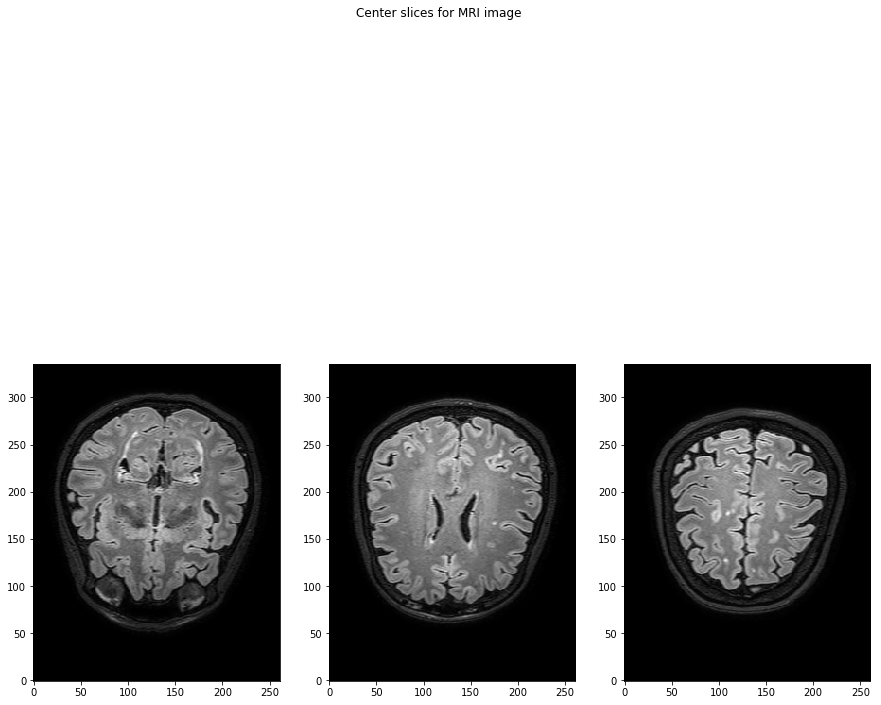

In [41]:
slice_0 = img[:, :, 190]
slice_1 = img[:, :, 224]
slice_2 = img[:, :, 250]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image")

Text(0.5,0.98,'Center slices for MRI image segmented by prediction')

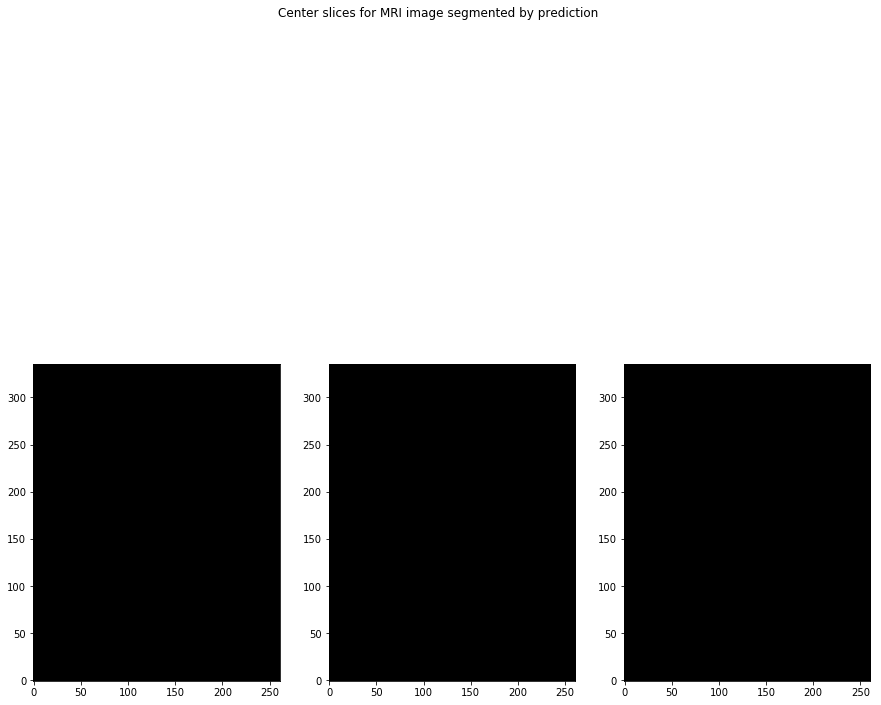

In [42]:
slice_0 = img_seg[:, :, 190]
slice_1 = img_seg[:, :, 224]
slice_2 = img_seg[:, :, 250]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented by prediction")

Text(0.5,0.98,'Center slices for MRI image segmented original')

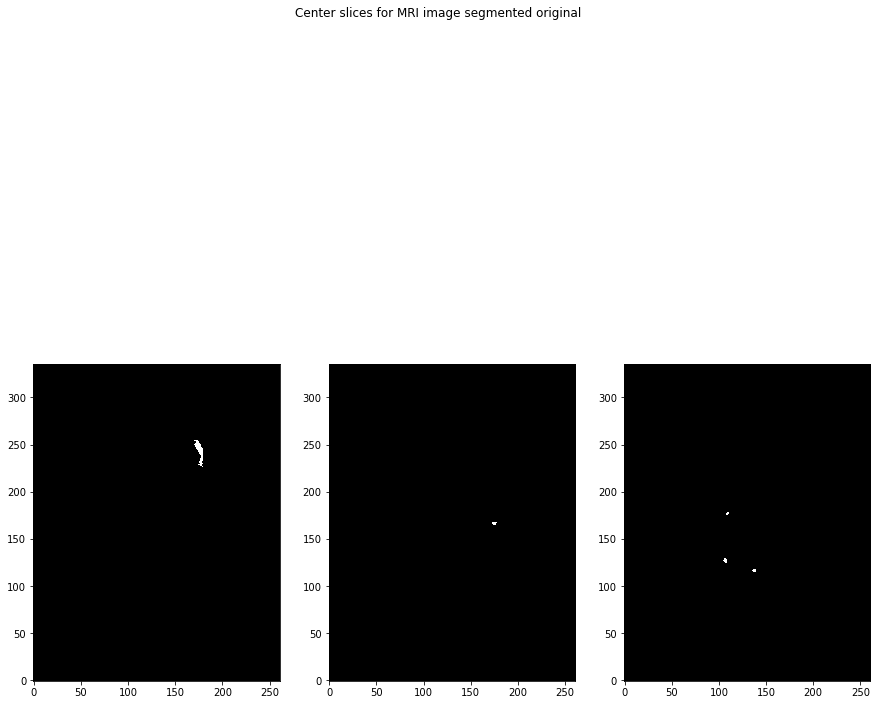

In [43]:
slice_0 = img_seg_original[:, :, 190]
slice_1 = img_seg_original[:, :, 224]
slice_2 = img_seg_original[:, :, 250]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented original")

In [69]:
import time

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

13:50:15
